In [1]:
# import the necessary packages
import warnings
warnings.filterwarnings('ignore')


import pandas as pd
import numpy as np
from plotnine import *
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression # Linear Regression Model
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler #Z-score variables
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score #model evaluation
from sklearn.metrics import confusion_matrix, plot_confusion_matrix #model evaluation

from sklearn.model_selection import train_test_split # simple TT split cv
from sklearn.model_selection import KFold # k-fold cv
from sklearn.model_selection import LeaveOneOut #LOO cv
from sklearn.model_selection import cross_val_score # cross validation metrics
from sklearn.model_selection import cross_val_predict # cross validation metrics

pd.set_option('display.max_rows', 400)

%matplotlib inline

# Project 1

Pretend that you've been hired as a data science consultant by a public health company to do some data analyses on a [diabetes dataset](https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/diabetes2.csv). They ask you two questions:

### Question 1. Can BMI be predicted using all the other variables in the dataset? What are the relationships between our predictor variables and BMI? Which variable has the largest effect on BMI? Will this model accurately predict BMI in other similar datasets?

### Question 2. Can Diabetes (measured in the `Outcome` column, 0 indicates no diabetes, 1 indicates diabetes diagnosis) be predicted using all the other variables in the dataset? What are the relationships between our predictor variables and diabetes? Which variable has the largest effect on Diabetes diagnosis? Will this model accurately predict Diabetes in other similar datasets?

They've asked you to do some analyses and make a write up for these questions. Use code AND markdown cells to create a write up that answers the two questions above. Your write up should be something you could show you "clients" to answer their questions, like a report to present. Your write up for *each* question should include:

- a) The code for your model(s)
- b) A short explanation of why you chose each model
- c) Interpretations of the coefficents for each model<sup>1</sup>
- d) Explicit answers to each part of the Question asked by the public health company
- e) Written justifications for choices made (such as which variables to z-score, method of model validation...etc)
- f) A clear and concise interpretation of how well each of your models performed, and justification for which metrics you used to determine that
- g) Visualizations using ggplot (minimum 2 *per* question, but as many as needed) that help communicate the answers you give.

DO NOT answer any of these questions using code comments, written parts of the write up must be in markdown. Pretend that you are creating these write-ups be read by people who are NOT data scientists/statisticians, therefore try to communicate your points/justifications/answers clearly and address them to an audience who does not know a lot about data science. Get rid of superflous code, and make the reports consise, complete, and clean!

You will be graded on:
- the appropriateness of your modeling/visualization choices and their justifications,
- the clarity and effectiveness of your answers, visualizations and explanations, and
- the completeness/elegance of your analyses


<sup>1</sup>(if you use KFold or LOO, then for each predictor variable (and intercept) take the average coefficient value across all the models you made OR once you've looked at the average test set error from the cross validation, refit your model using ALL the data and grab the coefficients from that model.)

## Question 1

### Data Exploration

In [2]:
dfRaw = pd.read_csv("https://raw.githubusercontent.com/cmparlettpelleriti/CPSC392ParlettPelleriti/master/Data/diabetes2.csv")

validPoints = ((dfRaw['Glucose'] != 0) & 
               (dfRaw['BloodPressure'] != 0) &
               (dfRaw['Insulin'] != 0) &
               (dfRaw['BMI'] != 0))

df = dfRaw.loc[validPoints]

#df.head(100)

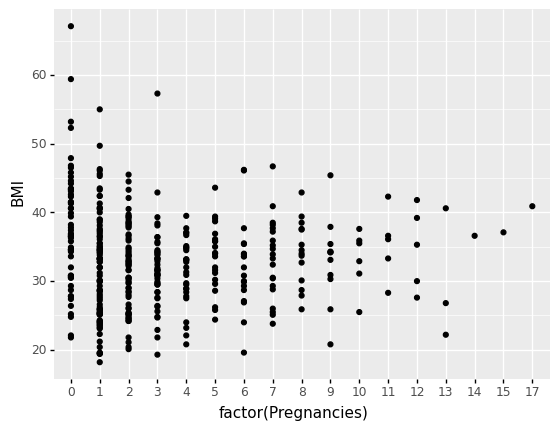

<ggplot: (112296846707)>

In [3]:
(ggplot(df, aes(x="factor(Pregnancies)", y="BMI")) + geom_point())

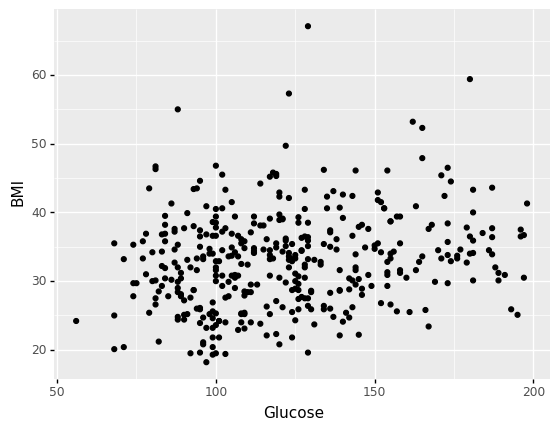

<ggplot: (112297012755)>

In [4]:
(ggplot(df, aes(x="Glucose", y="BMI")) + geom_point())

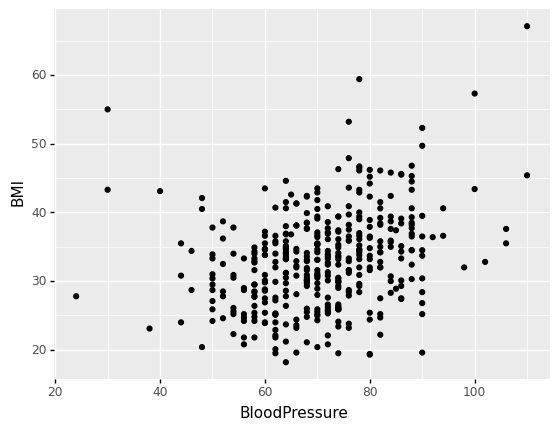

<ggplot: (112277920516)>

In [5]:
(ggplot(df, aes(x="BloodPressure", y="BMI")) + geom_point())

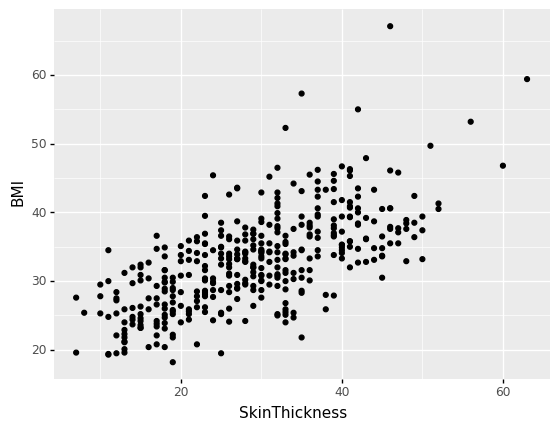

<ggplot: (112299202554)>

In [6]:
(ggplot(df, aes(x="SkinThickness", y="BMI")) + geom_point())

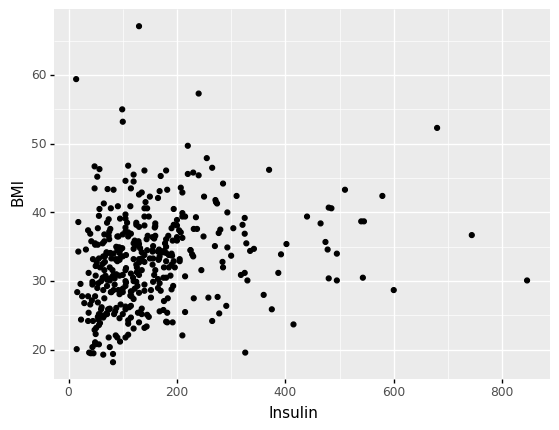

<ggplot: (112299202488)>

In [7]:
(ggplot(df, aes(x="Insulin", y="BMI")) + geom_point())

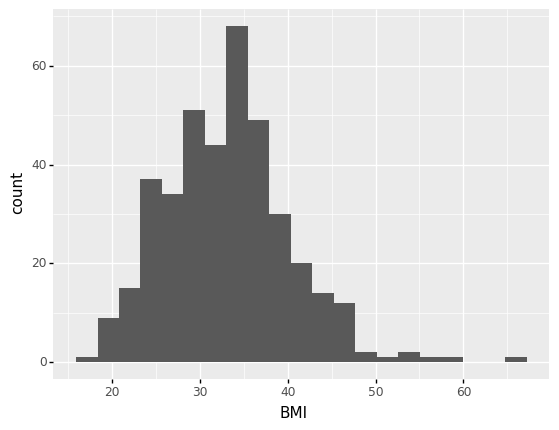

<ggplot: (112299310782)>

In [8]:
(ggplot(df, aes("BMI")) + geom_histogram())

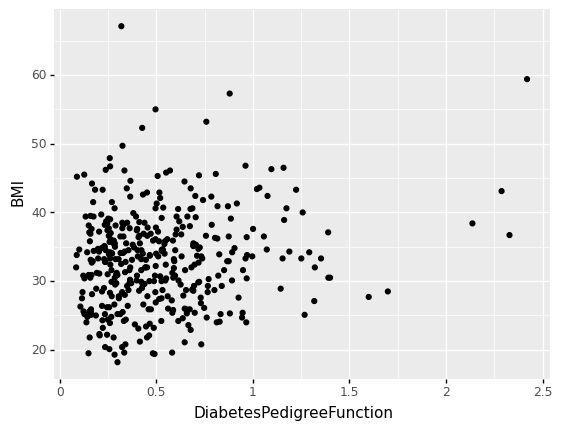

<ggplot: (112299199642)>

In [9]:
(ggplot(df, aes(x="DiabetesPedigreeFunction", y="BMI")) + geom_point())

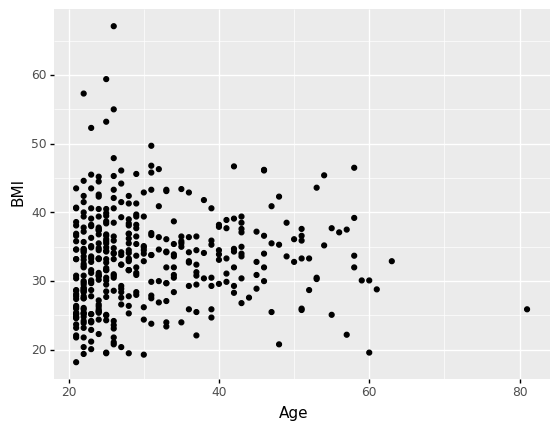

<ggplot: (112296846788)>

In [10]:
(ggplot(df, aes(x="Age", y="BMI")) + geom_point())

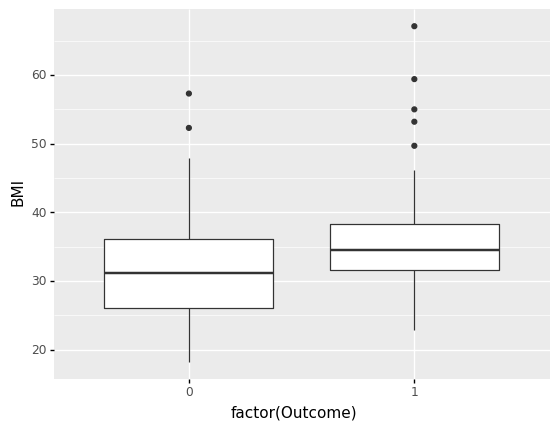

<ggplot: (112299321844)>

In [11]:
(ggplot(df, aes(x="factor(Outcome)", y="BMI")) + geom_boxplot())

I am choosing to model the BMI of the subject group using a linear regression crossed validated with the Leave One Out method. The predicted variable (BMI) is a continuous value and there appear to be correlations (of varying strengths) between all other variables and BMI individually, which is a necessary fact for linear regression to be effective. Additionally, the data set is relatively small, so it is useful to include all data points to generate the model. Leave One Out was chosen above K-Fold because of its higher degree of consistency relative to K-Fold and because the time difference between the two cross validation methods is negligable in this case. 

In [13]:
predBMI = ["Pregnancies","Glucose","BloodPressure","SkinThickness","Insulin","DiabetesPedigreeFunction","Age","Outcome"]

x1 = df[predBMI]
y1 = df[["BMI"]]

loo = LeaveOneOut()
loo.get_n_splits(x1)

linReg = LinearRegression()

coefs = pd.DataFrame({"Pregnancies":[],
                      "Glucose":[],
                      "BloodPressure":[],
                      "SkinThickness":[],
                      "Insulin":[],
                      "DiabetesPedigreeFunction":[],
                      "Age":[],
                      "Outcome":[],
                      "Intercept":[],
                      "MSE":[]})

for train,test in loo.split(x1):
    x1_train = x1.iloc[train]
    y1_train = y1.iloc[train]
    x1_test = x1.iloc[test]
    y1_test = y1.iloc[test]
    
    linReg = LinearRegression().fit(x1_train, y1_train)
    
    coefs = coefs.append(pd.DataFrame({"Pregnancies":[linReg.coef_[0][0]],
                      "Glucose":[linReg.coef_[0][1]],
                      "BloodPressure":linReg.coef_[0][2],
                      "SkinThickness":linReg.coef_[0][3],
                      "Insulin":linReg.coef_[0][4],
                      "DiabetesPedigreeFunction":linReg.coef_[0][5],
                      "Age":linReg.coef_[0][6],
                      "Outcome":linReg.coef_[0][7],
                      "Intercept":linReg.intercept_[0]}))



After LOO is run, all of the coefficients calculated from each model are averaged together to create (hopefully) the most acurate model possible for unseen data.

In [14]:
# Average coefficients and intercepts from all LOO and fit to a linear regression object

linReg.intercept_ = np.array([coefs['Intercept'].mean()])
linReg.coef_ = np.array([[coefs['Pregnancies'].mean(),
                          coefs['Glucose'].mean(),
                          coefs['BloodPressure'].mean(),
                          coefs['SkinThickness'].mean(),
                          coefs['Insulin'].mean(),
                          coefs['DiabetesPedigreeFunction'].mean(),
                          coefs['Age'].mean(),
                          coefs['Outcome'].mean()]])

Because LOO cross validation is being run on unscaled predictors, it is unnecessary to scale the predictors themselves. Instead, the calculated coefficients of the linear regression are scaled instead. This allows examination of the absolute and relative relationship each predictor has with BMI.

Standardized coefficients are calculated by multiplying the standard deviation of the predictor and the unscaled coefficient.

In [15]:
# Calculate z-scored coefficients

x1std = x1.std()

linRegZ = LinearRegression()

linRegZ.intercept_ = y1['BMI'].mean()
linRegZ.coef_ = np.array([[(x1std['Pregnancies']) * coefs['Pregnancies'].mean(),
                          (x1std['Glucose']) * coefs['Glucose'].mean(),
                          (x1std['BloodPressure']) * coefs['BloodPressure'].mean(),
                          (x1std['SkinThickness']) * coefs['SkinThickness'].mean(),
                          (x1std['Insulin']) * coefs['Insulin'].mean(),
                          (x1std['DiabetesPedigreeFunction']) * coefs['DiabetesPedigreeFunction'].mean(),
                          (x1std['Age']) * coefs['Age'].mean(),
                          (x1std['Outcome']) * coefs['Outcome'].mean()]])

The simplest way to view the effectivness of the model is to plot the predicted values and the true values together as shown below. Points closer to the line are times where the model more accurately predicted the BMI of a given person. 

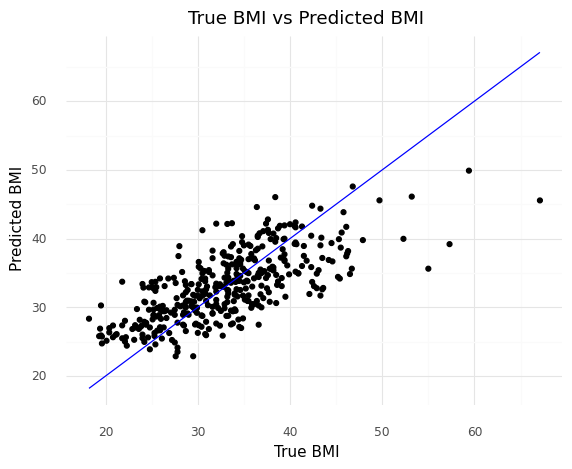

<ggplot: (112299622226)>

In [16]:
# Test effectiveness of model and plot errors

y1_pred = linReg.predict(x1)

testDf = pd.DataFrame({"True" : y1['BMI'], "Pred" : y1_pred[:,0], "Residuals" : (y1['BMI'] - y1_pred[:,0])})

(ggplot(testDf, aes(x = "True", y = "Pred")) + 
 geom_point() +
 geom_line(aes(x = "True", y = "True"), color="blue") +
 labs(x = "True BMI", y = "Predicted BMI") +
 ggtitle("True BMI vs Predicted BMI") +
 theme_minimal())

The next most intuitive way to view the effectivness of the model is to plot the true value vs the residuals. This directly shows how accurate each predicted value was compared to the true value. Points closer to zero are more accurate, points above the zero line were under-predicted and points below the zero line were over-predicted

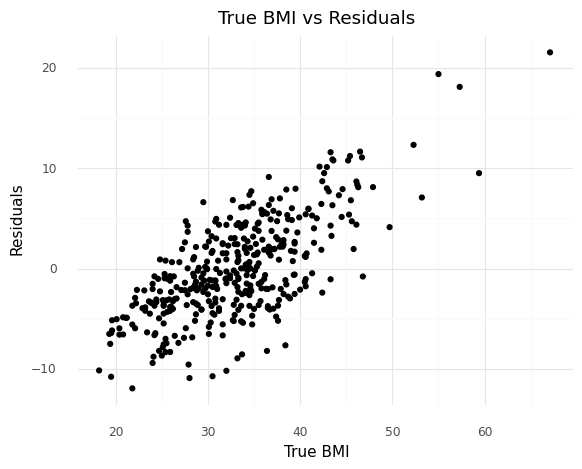

<ggplot: (112299315836)>

In [17]:
(ggplot(testDf, aes(x = "True", y = "Residuals")) + 
 geom_point() +
 labs(x = "True BMI", y = "Residuals") +
 ggtitle("True BMI vs Residuals") +
 theme_minimal())

Mean Squared Error is a numerical measure of how accurate the model is. It is the amount of variance in the data that is explained by the model.

In [18]:
print("MSE: " +  str(linReg.score(x1, y1)))

MSE: 0.5022736246883561


In [19]:
coefs = pd.DataFrame({"Name": predBMI, "Coef":linReg.coef_[0], "CoefZ":linRegZ.coef_[0]})
coefs = coefs.append(pd.DataFrame({"Name":"Intercept", "Coef": linReg.intercept_, "CoefZ": linRegZ.intercept_}))

coefs.head(9)

,Name,Coef,CoefZ
0,Pregnancies,-0.228033,-0.732310
1,Glucose,-0.004486,-0.138430
2,BloodPressure,0.103319,1.291083
3,SkinThickness,0.398048,4.186045
4,Insulin,0.005745,0.682732
5,DiabetesPedigreeFunction,0.817608,0.282474
6,Age,-0.047709,-0.486673
7,Outcome,1.576675,0.743247
0,Intercept,15.112361,33.086224


The coefficients are interpreted as follows:

0. Pregnancies: For each pregnancy a person has, their predicted BMI decreases by 0.228 kg/m<sup>2</sup>. This corresponds to a decrease in predicted BMI by 0.732 kg/m<sup>2</sup> for each increase in Pregnancies by one standard deviation.
1. Glucose: For each unit of plasma glucose concentration for a given person, their predicted BMI decreases by 0.004 kg/m<sup>2</sup>. This corresponds to a decrease in predicted BMI by 0.138 kg/m<sup>2</sup> for each increase in plasma glucose concentration by one standard deviation.
2. Blood Pressure: For each increase in blood pressure by one (mm Hg) a person has, their predicted BMI increases by 0.103 kg/m<sup>2</sup>. This corresponds to an increase in predicted BMI by 1.291 kg/m<sup>2</sup> for each increase in blood presure by one standard deviation.
3. Skin Thickness: For each increase in skin thickness by one mm a person has, their predicted BMI increases by 0.398 kg/m<sup>2</sup>. This corresponds to an increase in predicted BMI by 4.186 kg/m<sup>2</sup> for each increase in skin thickness by one standard deviation.
3. Insulin: For each increase in Insulin by one (mu U/ml) a person has, their predicted BMI increases by 0.006 kg/m<sup>2</sup>. This corresponds to an increase in predicted BMI by 0.683 kg/m<sup>2</sup> for each increase in Insulin by one standard deviation.
3. Diabetes Pedigree Function: For each increase in DPF by one unit a person has, their predicted BMI increases by 0.818 kg/m<sup>2</sup>. This corresponds to an increase in predicted BMI by 0.282 kg/m<sup>2</sup> for each increase in DPF by one standard deviation.
3. Age: For each year older a person is, their predicted BMI decreases by 0.048 kg/m<sup>2</sup>. This corresponds to a decrease in predicted BMI by 0.487 kg/m<sup>2</sup> for each increase in age by one standard deviation.
3. Outcome: If a person has diabetes, their predicted BMI increases by 1.577 kg/m<sup>2</sup>.
3. Intercept: The unscaled intercept is nonsensical because it is impossible for many of the predictors to have values of zero, so it is simply a point of reference for the model. The Scaled intercept means that a completely average person would have a BMI of about 33.1 kg/m<sup>2</sup> for this population. (Note: the scaled intercept is about 0.003 kg/m<sup>2</sup> off what it should be. This is because an approximation was used when calculating the scaled intercept)


BMI can be roughly predicted using the other variables in the dataset. About 50% of variance in outcome is explained by the model, and it stays fairly homoscedastic until the values for BMI reach the extreme ends of the scale.

Some variables have very strong correlations with BMI, namely Skin Thickness, Blood Pressure, and whether someone has diabetes or not. Some other variables had significantly weaker correlations and little homoscedasticity and might have actually made the model more inaccurate as a result, namely DPF, age, pregnancies, and insulin. Glucose had very little impact on the model at all.

Skin thickness had the gretest effect on BMI. This makes sense because BMI is a rough measure of density found by dividing a person's weight by their height squared. Thicker skin would make someone heavier but not make them taller.

This model will do a reasonable job of predicting BMI in similar datasets so long as the actual BMI of the subject stays between 20-40. The model is very inaccurate for larger values.

## Question 2

### Data Exploration

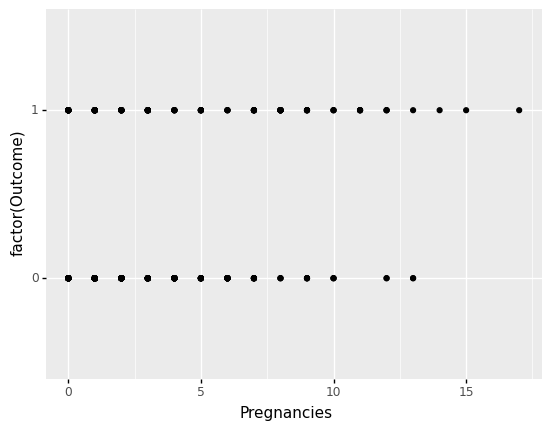

<ggplot: (112299687638)>

In [20]:
(ggplot(df, aes(x="Pregnancies", y="factor(Outcome)")) + geom_point())

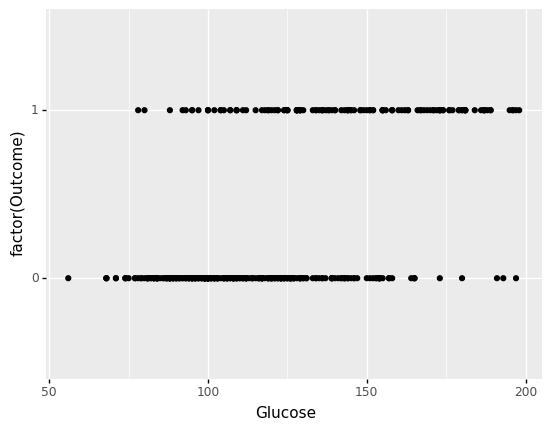

<ggplot: (112299681765)>

In [21]:
(ggplot(df, aes(x="Glucose", y="factor(Outcome)")) + geom_point())

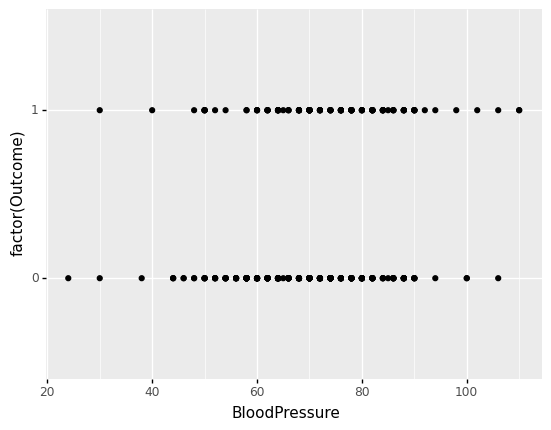

<ggplot: (112299661629)>

In [22]:
(ggplot(df, aes(x="BloodPressure", y="factor(Outcome)")) + geom_point())

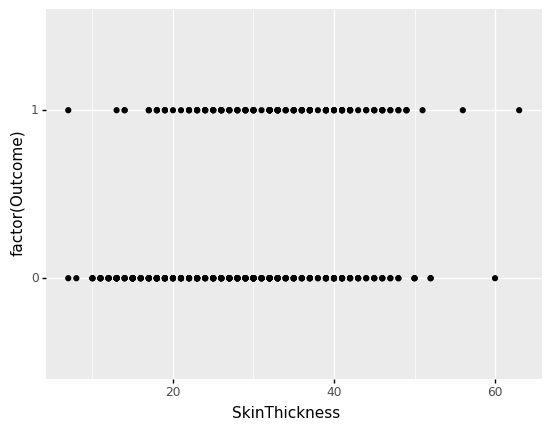

<ggplot: (112299687491)>

In [23]:
(ggplot(df, aes(x="SkinThickness", y="factor(Outcome)")) + geom_point())

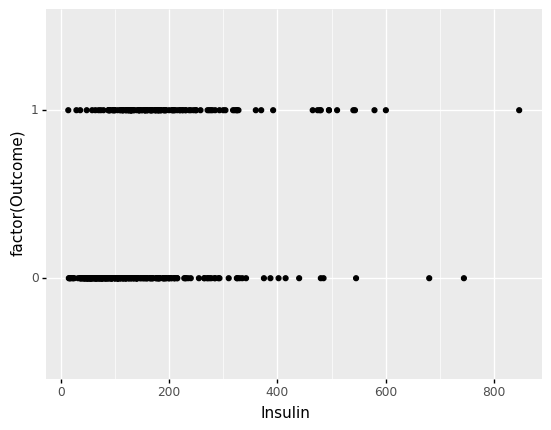

<ggplot: (112302115316)>

In [24]:
(ggplot(df, aes(x="Insulin", y="factor(Outcome)")) + geom_point())

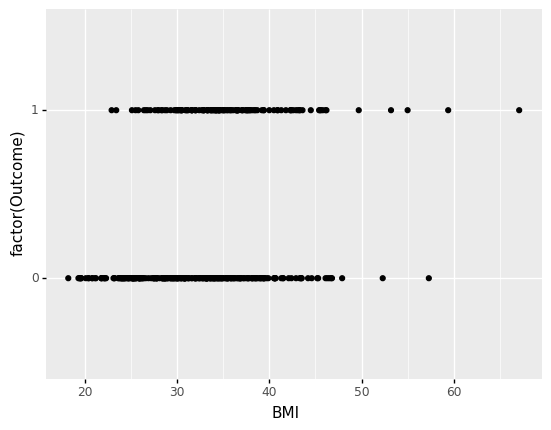

<ggplot: (112299244502)>

In [25]:
(ggplot(df, aes(x="BMI", y="factor(Outcome)")) + geom_point())

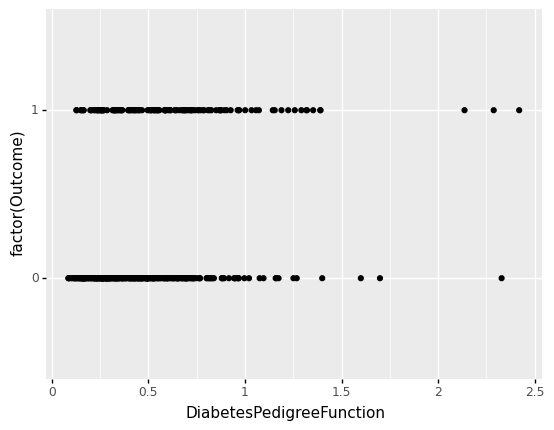

<ggplot: (112299267277)>

In [26]:
(ggplot(df, aes(x="DiabetesPedigreeFunction", y="factor(Outcome)")) + geom_point())

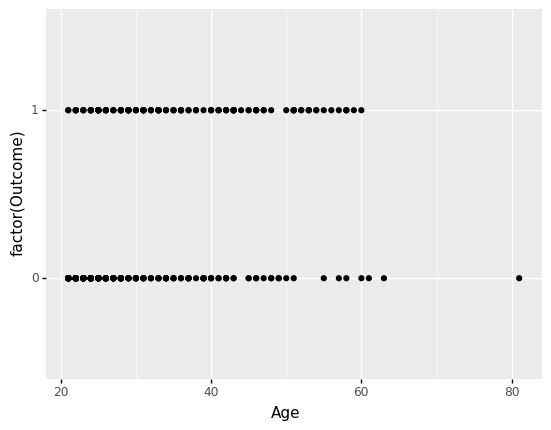

<ggplot: (112299709398)>

In [27]:
(ggplot(df, aes(x="Age", y="factor(Outcome)")) + geom_point())

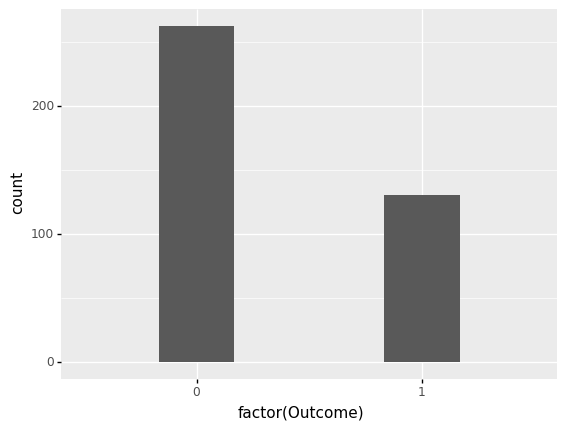

<ggplot: (112299650603)>

In [28]:
(ggplot(df, aes("factor(Outcome)")) + geom_histogram())

When predicting if someone from the population has diabetes, it is best to use a Logistic Regression model because they are very effective at preditcing the log odds that something is true or false. Log odds can then be translated into probability with a relatively simple calculation. Train Test Split cross validation was used because of it's simplicity of implementation and high degree of flexibility when working with large data sets.

Every predictor variable is standardized because each one is a continuous variable of some kind. The pregnancies predictor could be left un-standardized because it could be interpreted as categorical, as it is only possible to have whole numbers of pregnancies, however it was standardized in this case to be able to analyze its coresponding coefficient in the linear regression in terms of its z-score so that it's relative impact on the prediction is more visible.

In [29]:
predOut = ["Pregnancies","Glucose","BloodPressure","SkinThickness","Insulin","BMI","DiabetesPedigreeFunction","Age"]

x2 = df[predOut]
y2 = df[["Outcome"]]

logReg = LogisticRegression()

x2_train, x2_test, y2_train, y2_test = train_test_split(x2, y2, test_size=0.2)

z2 = StandardScaler()
z2.fit(x2_train)

x2_train = z2.transform(x2_train)
x2_test = z2.transform(x2_test)

logReg.fit(x2_train, y2_train)

LogisticRegression()

When working with logistic regressions, it is good practice to calculate its accuracy score to get the raw percentage of correct predictions, as well as plot a confusion matrix to determine where exactly the model made its mistakes.

The logistic regression is 78.48101265822784% accurate.


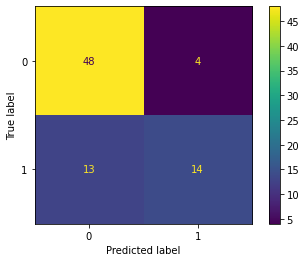

In [30]:
predictedVals = logReg.predict(x2_test)
print("The logistic regression is " + str(accuracy_score(y2_test, predictedVals) * 100) + "% accurate.")

plot_confusion_matrix(logReg, x2_test, y2_test)

One step farther than a confusion matrix is to plot the predicted probability for each data point. This shows how confident the model was in each prediction. In the plot below, red points close to the center line show that the model was on the cusp of guessing correctly, and red points farther away from the center line show times where the model confidently guessed wrong.

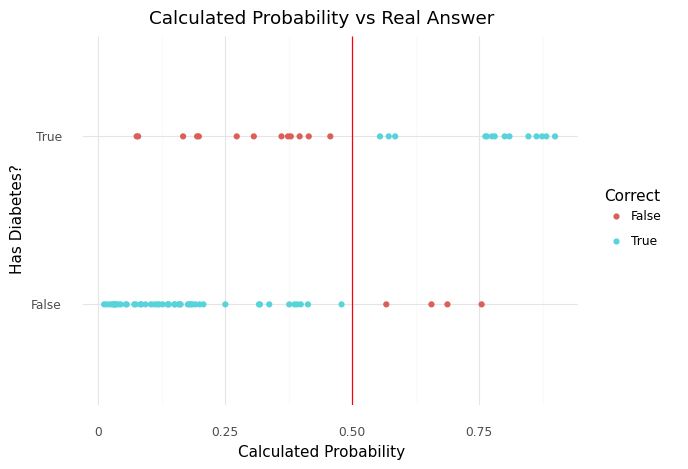

<ggplot: (112302162351)>

In [31]:
proba = logReg.predict_proba(x2_test)

testDf2 = pd.DataFrame({"Real01":y2_test["Outcome"], "Pred":predictedVals.tolist(), "Proba":proba[:,1]})


testDf2["Correct"] = testDf2["Real01"] == testDf2["Pred"]
testDf2["Real"] = testDf2["Real01"] == 1

(ggplot(testDf2, aes(x="Proba", y="Real", color="Correct")) + 
 geom_point() +
 geom_vline(xintercept=0.5, color = "red") +
 labs(x = "Calculated Probability", y = "Has Diabetes?") +
 ggtitle("Calculated Probability vs Real Answer") +
 theme_minimal()
)

The histogram below shows the relative proportions of correct and incorrect guesses.

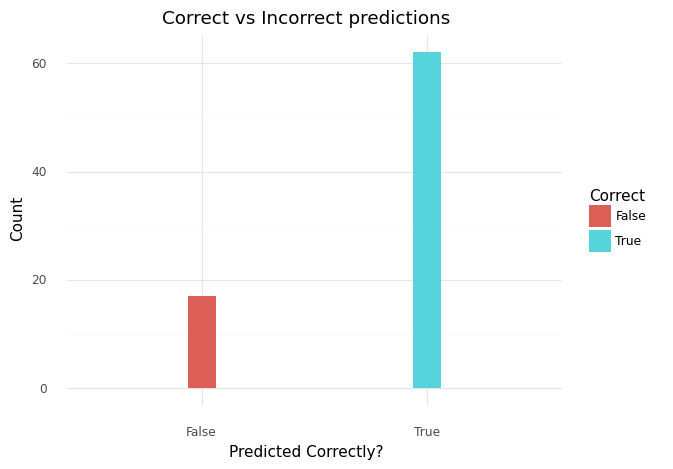

<ggplot: (112302169107)>

In [32]:
(ggplot(testDf2, aes(x="Correct", fill="Correct")) + 
 geom_histogram() +
 labs(x = "Predicted Correctly?", y = "Count") +
 ggtitle("Correct vs Incorrect predictions") +
 theme_minimal()
)

In [36]:
coefs2 = pd.DataFrame({"Name": predOut, "CoefLO":logReg.coef_[0]})
coefs2 = coefs2.append(pd.DataFrame({"Name":"Intercept", "CoefLO": logReg.intercept_}))
coefs2["CoefO"] = np.exp(coefs2["CoefLO"])
coefs2.head(9)

,Name,CoefLO,CoefO
0,Pregnancies,0.424307,1.528531
1,Glucose,1.156224,3.177911
2,BloodPressure,-0.042138,0.958737
3,SkinThickness,0.052844,1.054265
4,Insulin,-0.063696,0.938291
5,BMI,0.541904,1.719277
6,DiabetesPedigreeFunction,0.279414,1.322355
7,Age,0.220166,1.246283
0,Intercept,-0.997848,0.368672


The Coefficinets for the Logistic Regression are interpreted as follows:
1. Pregnancies: An increase in the number of pregnancies by one standard deviation corresponds to a 0.424 increase in Log Odds of having diabetes. For the same increase in number of pregnancies, the odds are multiplied by 1.528.
1. Glucose: An increase in plasma glucose concentration by one standard deviation corresponds to a 1.156 increase in Log Odds of having diabetes. For the same increase in plasma glucose concentration, the odds are multiplied by 3.178.
1. Blood Pressure: An increase in blood pressure by one standard deviation corresponds to a 0.042 decrease in Log Odds of having diabetes. For the same increase in blood pressure, the odds are multiplied by 0.959.
1. Skin Thickness: An increase in skin thickness by one standard deviation corresponds to a 0.053 increase in Log Odds of having diabetes. For the same increase in skin thickness, the odds are multiplied by 1.054.
1. Insulin: An increase in insulin levels by one standard deviation corresponds to a 0.064 decrease in Log Odds of having diabetes. For the same increase in skin thickness, the odds are multiplied by 0.938.
1. BMI: An increase in BMI by one standard deviation corresponds to a 0.542 increase in Log Odds of having diabetes. For the same increase in skin thickness, the odds are multiplied by 1.719.
1. Diabetes Pedigree Function: An increase in DPF by one standard deviation corresponds to a 0.279 increase in Log Odds of having diabetes. For the same increase in skin thickness, the odds are multiplied by 1.322.
1. Age: An increase in Age by one standard deviation corresponds to a 0.220 increase in Log Odds of having diabetes. For the same increase in skin thickness, the odds are multiplied by 1.146.
1. An average member of the Pima Indian tribe would have a log odds of having diabetes of -0.998 which corresponds to a probability of 0.2694.

Diabetes can be predicted using the other variables in the data set, however logistic regression might not be the best model for the job. Most of the predictors have a positive relationship with the probability of having diabetes (the only outliers being blood pressure and insulin levels). Blood pressure, skin thickness, and insulin have relatively small effects on the outcome of the prediction. Plasma glucose concentraction is the strongest predictor of diabetes in this model. This model is fairly inaccurate and often produces false negatives, which is very bad for medical diagonices.

The model was only about 78% accurate, and as stated earlier, had many false negatives. The performance is certainly subpar for a medical prediction model, however the dataset is very small compared to the broader population of the world, so perhaps with more data, a similar logistic regression model would fair better. 